<a href="https://colab.research.google.com/github/NandhithaMilkuri/Batch20_1352_PDS/blob/main/Project_code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

🚀 Training LinearRegression...
✅ LinearRegression: R2=0.913, RMSE=0.500, MAE=0.399
🚀 Training RandomForest...
✅ RandomForest: R2=0.912, RMSE=0.503, MAE=0.401
🚀 Training LightGBM...


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


✅ LightGBM: R2=0.913, RMSE=0.500, MAE=0.399

📊 Model Performance:
               Model        R2      RMSE       MAE
0  LinearRegression  0.913476  0.499567  0.398541
1      RandomForest  0.912417  0.502613  0.400944
2          LightGBM  0.913202  0.500355  0.399182

📌 Best Model: LinearRegression


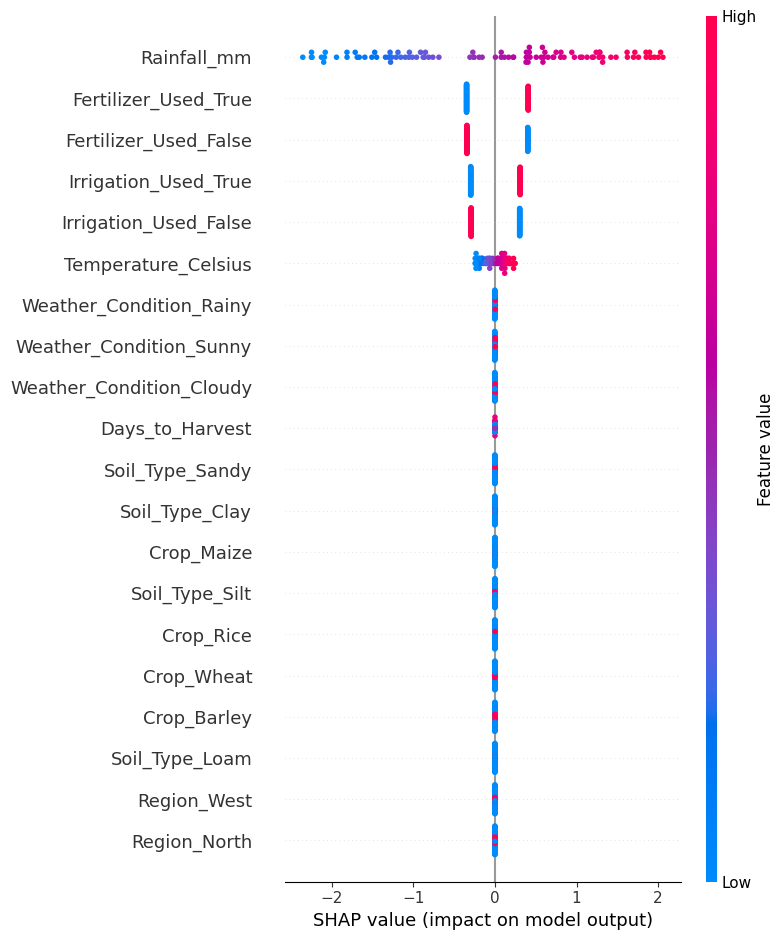

In [3]:
# ================================
# 1. Imports
# ================================
import pandas as pd
import numpy as np
import shap

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

# Models (fast ones)
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor

# ================================
# 2. Load dataset
# ================================
df = pd.read_csv("crop_yield.csv", low_memory=False)

# Clean data
df = df.drop_duplicates().reset_index(drop=True)
df = df.fillna(df.median(numeric_only=True))

# ================================
# 3. Features & Target
# ================================
target = "Yield_tons_per_hectare"
X = df.drop(columns=[target])
y = df[target]

numeric_features = ['Rainfall_mm', 'Temperature_Celsius', 'Days_to_Harvest']
categorical_features = ['Region', 'Soil_Type', 'Crop',
                        'Fertilizer_Used', 'Irrigation_Used', 'Weather_Condition']

# 🔑 FIX: Force categorical columns to string to avoid mixed bool/str issue
for col in categorical_features:
    X[col] = X[col].astype(str)

# ================================
# 4. Preprocessing
# ================================
numeric_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

preprocessor = ColumnTransformer([
    ('num', numeric_transformer, numeric_features),
    ('cat', categorical_transformer, categorical_features)
])

# ================================
# 5. Train/Test Split
# ================================
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# ================================
# 6. FAST Models
# ================================
models = {
    "LinearRegression": LinearRegression(),
    "RandomForest": RandomForestRegressor(n_estimators=50, max_depth=8, n_jobs=-1, random_state=42),
    "LightGBM": LGBMRegressor(n_estimators=50, learning_rate=0.1, random_state=42, verbose=-1)
}

# ================================
# 7. Training & Evaluation
# ================================
results = []
for name, model in models.items():
    print(f"🚀 Training {name}...")
    pipe = Pipeline([('preprocessor', preprocessor),
                     ('model', model)])

    pipe.fit(X_train, y_train)
    preds = pipe.predict(X_test)

    r2 = r2_score(y_test, preds)
    rmse = np.sqrt(mean_squared_error(y_test, preds))
    mae = mean_absolute_error(y_test, preds)

    results.append([name, r2, rmse, mae])
    print(f"✅ {name}: R2={r2:.3f}, RMSE={rmse:.3f}, MAE={mae:.3f}")

# Save results
results_df = pd.DataFrame(results, columns=["Model", "R2", "RMSE", "MAE"])
print("\n📊 Model Performance:\n", results_df)

# ================================
# 8. SHAP Explainability (on best model)
# ================================
best_model_name = results_df.sort_values("R2", ascending=False).iloc[0, 0]
print(f"\n📌 Best Model: {best_model_name}")

best_model = models[best_model_name]
best_pipe = Pipeline([('preprocessor', preprocessor),
                      ('model', best_model)])
best_pipe.fit(X_train, y_train)

# SHAP (on small sample for speed)
X_sample = X_test.sample(100, random_state=42)
X_sample_transformed = best_pipe.named_steps['preprocessor'].transform(X_sample)

explainer = shap.Explainer(best_pipe.named_steps['model'], X_sample_transformed)
shap_values = explainer(X_sample_transformed)

# Plot SHAP summary
shap.summary_plot(
    shap_values,
    X_sample_transformed,
    feature_names=(numeric_features +
                   list(preprocessor.named_transformers_['cat']
                        .named_steps['onehot']
                        .get_feature_names_out(categorical_features)))
)


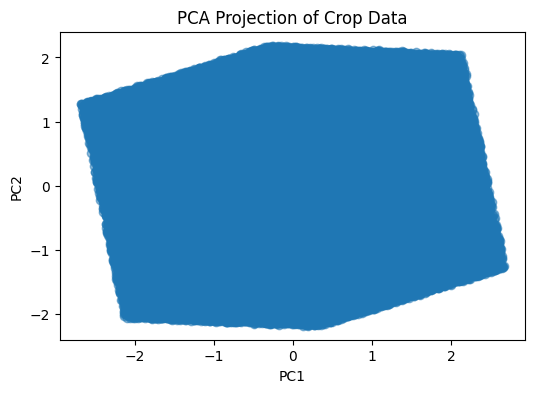

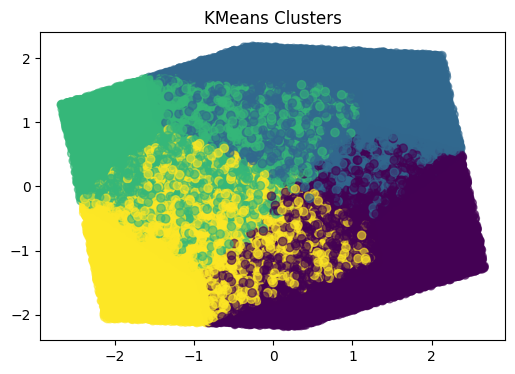

In [ ]:
# ================================
# Step 6: Unsupervised Learning
# ================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from scipy.cluster.hierarchy import dendrogram, linkage

# ================================
# 1. Load Dataset
# ================================
df = pd.read_csv("crop_yield.csv", low_memory=False)

# Drop target (not needed for unsupervised)
df_unsupervised = df.drop(columns=["Yield_tons_per_hectare"])

# ================================
# 2. Features
# ================================
numeric_features = ['Rainfall_mm', 'Temperature_Celsius', 'Days_to_Harvest']
categorical_features = ['Region', 'Soil_Type', 'Crop',
                        'Fertilizer_Used', 'Irrigation_Used', 'Weather_Condition']

# 🔑 Force categorical columns to string to avoid mixed types
for col in categorical_features:
    df_unsupervised[col] = df_unsupervised[col].astype(str)

# ================================
# 3. Preprocessing
# ================================
numeric_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

preprocessor = ColumnTransformer([
    ('num', numeric_transformer, numeric_features),
    ('cat', categorical_transformer, categorical_features)
])

X_processed = preprocessor.fit_transform(df_unsupervised)

# ================================
# 4. PCA for Dimensionality Reduction
# ================================
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_processed)

plt.figure(figsize=(6,4))
plt.scatter(X_pca[:,0], X_pca[:,1], alpha=0.5)
plt.title("PCA Projection of Crop Data")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

# ================================
# 5. KMeans Clustering
# ================================
kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
labels_kmeans = kmeans.fit_predict(X_processed)

plt.figure(figsize=(6,4))
plt.scatter(X_pca[:,0], X_pca[:,1], c=labels_kmeans, cmap="viridis", alpha=0.6)
plt.title("KMeans Clusters")
plt.show()

# ================================
# 6. Hierarchical Clustering
# ================================
hier = AgglomerativeClustering(n_clusters=4)
labels_hier = hier.fit_predict(X_processed)

plt.figure(figsize=(6,4))
plt.scatter(X_pca[:,0], X_pca[:,1], c=labels_hier, cmap="plasma", alpha=0.6)
plt.title("Hierarchical Clustering")
plt.show()

# Dendrogram
plt.figure(figsize=(8,4))
linkage_matrix = linkage(X_processed[:200], method='ward')  # sample for speed
dendrogram(linkage_matrix, truncate_mode="level", p=5)
plt.title("Hierarchical Dendrogram (sample)")
plt.show()

# ================================
# 7. DBSCAN Clustering
# ================================
dbscan = DBSCAN(eps=3, min_samples=10, n_jobs=-1)
labels_dbscan = dbscan.fit_predict(X_processed)

plt.figure(figsize=(6,4))
plt.scatter(X_pca[:,0], X_pca[:,1], c=labels_dbscan, cmap="coolwarm", alpha=0.6)
plt.title("DBSCAN Clusters")
plt.show()

# ================================
# 8. Cluster Summary
# ================================
df_clusters = df_unsupervised.copy()
df_clusters["KMeans_Cluster"] = labels_kmeans
df_clusters["Hierarchical_Cluster"] = labels_hier
df_clusters["DBSCAN_Cluster"] = labels_dbscan

print("\n📊 Cluster Sizes:")
print(df_clusters.groupby("KMeans_Cluster").size())

print("\n📌 Sample Clustered Data:")
print(df_clusters.head())


In [1]:
# ================================
# Step 7: Reinforcement Learning
# ================================

import pandas as pd
import numpy as np
import random

# ================================
# 1. Load Dataset
# ================================
df = pd.read_csv("crop_yield.csv", low_memory=False)

# Convert categorical features to string
categorical_features = ['Region', 'Soil_Type', 'Crop',
                        'Fertilizer_Used', 'Irrigation_Used', 'Weather_Condition']
for col in categorical_features:
    df[col] = df[col].astype(str)

# ================================
# 2. Simplify Environment Setup
# ================================
# State: (Rainfall, Temperature, Soil_Type, Crop, Weather)
# Action: Choose Fertilizer / Irrigation
# Reward: Yield
# Environment: From dataset

states = list(zip(df['Rainfall_mm'], df['Temperature_Celsius'],
                  df['Soil_Type'], df['Crop'], df['Weather_Condition']))

actions = list(zip(df['Fertilizer_Used'], df['Irrigation_Used']))
rewards = df['Yield_tons_per_hectare'].values

# Encode states and actions as integers
state_dict = {s:i for i,s in enumerate(set(states))}
action_dict = {a:i for i,a in enumerate(set(actions))}

n_states = len(state_dict)
n_actions = len(action_dict)

# ================================
# 3. Q-Learning Setup
# ================================
Q = np.zeros((n_states, n_actions))

alpha = 0.1      # learning rate
gamma = 0.9      # discount factor
epsilon = 0.2    # exploration probability
episodes = 5000  # training iterations

# ================================
# 4. Training Loop
# ================================
for ep in range(episodes):
    idx = random.randint(0, len(states)-1)
    state = state_dict[states[idx]]
    action = random.choice(list(action_dict.values()))
    reward = rewards[idx]

    # Update Q-table
    Q[state, action] = Q[state, action] + alpha * (
        reward + gamma * np.max(Q[state, :]) - Q[state, action]
    )

print("✅ Q-Learning Training Completed!")

# ================================
# 5. Extract Optimal Policy
# ================================
policy = {s: np.argmax(Q[i]) for s, i in state_dict.items()}

# Convert back to readable actions
inv_action_dict = {v:k for k,v in action_dict.items()}

print("\n📌 Sample Learned Policy (State → Best Action):")
for i, (s, a_idx) in enumerate(policy.items()):
    if i > 10: break
    print(f"State={s} → Action={inv_action_dict[a_idx]}")


✅ Q-Learning Training Completed!

📌 Sample Learned Policy (State → Best Action):
State=(393.88624856016247, 34.31887270019119, 'Peaty', 'Wheat', 'Cloudy') → Action=('True', 'False')
State=(181.5415028713481, 24.861925258209148, 'Loam', 'Wheat', 'Rainy') → Action=('True', 'False')
State=(748.5904895297774, 27.106675054971557, 'Chalky', 'Maize', 'Rainy') → Action=('True', 'False')
State=(864.8531887400044, 19.20054316139777, 'Silt', 'Barley', 'Sunny') → Action=('True', 'False')
State=(847.4647564306148, 31.27341166372008, 'Clay', 'Cotton', 'Sunny') → Action=('True', 'False')
State=(600.3262259895148, 32.28706439472311, 'Clay', 'Wheat', 'Sunny') → Action=('True', 'False')
State=(874.0220540986581, 35.85906304796981, 'Sandy', 'Barley', 'Cloudy') → Action=('True', 'False')
State=(150.31742696404012, 16.365585289938434, 'Chalky', 'Rice', 'Cloudy') → Action=('True', 'False')
State=(981.7847535812184, 26.82756872568952, 'Chalky', 'Soybean', 'Rainy') → Action=('True', 'False')
State=(575.752204